## Get a simple image
download a sample image from Google - https://www.istockphoto.com/photos/red-fox

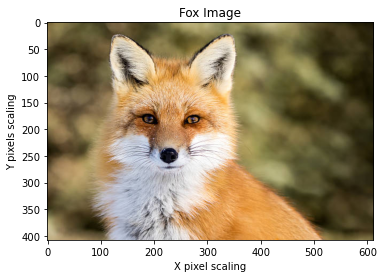

In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.title("Fox Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread('images/fox.jpg')
plt.imshow(image)
plt.show()  

In [2]:
# allow downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# # ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

Load the model chosen, in this particular case it was selected the ResNet50 Model

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# load the model
model=ResNet50(weights='imagenet')
#model=ResNet50V2(weights='imagenet')

2022-09-19 04:04:47.846970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 04:04:51.909701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 Load and prepare Image.

  The image is loaded as pixel data and prepare it to be presented to the network

In [5]:
from tensorflow.keras.preprocessing.image import load_img
# load an image from file
redfox = load_img('images/fox.jpg', target_size=(224, 224))

In [6]:
#redfox.shape

In [7]:
from tensorflow.keras.preprocessing.image import load_img
# load an image from file
redfox = load_img('images/fox.jpg', target_size=(224, 224))
#redfox = load_img('images/fox.jpg' )

from tensorflow.keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
redfox = img_to_array(redfox)

# reshape data for the model
redfox = redfox.reshape(1, redfox.shape[0], redfox.shape[1], redfox.shape[2])

from tensorflow.keras.applications.resnet50 import preprocess_input
# prepare the image for the ResNet50 model
redfox = preprocess_input(redfox)

Predication of red-fox

In [8]:
# predict the probability across all output classes
yhat = model.predict(redfox)   

1/1 [==============================] - 1s 700ms/step


Interpret predictions

In [9]:
# convert the probabilities to class labels
from tensorflow.keras.applications.resnet50 import decode_predictions
label = decode_predictions(yhat)

In [10]:
# retrieve the three most likely results, e.g. highest probability
label_1 = label[0][0]
label_2 = label[0][1]
label_3 = label[0][2]

In [11]:
# print the classification

print('%s (%.2f%%)' % (label_1[1], label_1[2]*100))
print('%s (%.2f%%)' % (label_2[1], label_2[2]*100))
print('%s (%.2f%%)' % (label_3[1], label_3[2]*100))

red_fox (87.62%)
kit_fox (9.92%)
dhole (1.53%)


ResNet50V2 versus ResNet50 results:
```
red_fox (87.62%)
kit_fox (9.92%)
dhole (1.53%)
```

## Visualize Filters
Use https://keras.io/examples/vision/visualizing_what_convnets_learn/ to 
visualize the features map using : layer_name = "conv4_block2_out", and using the ResNet50V2 model, obtaining the following results for 0 filter, and first 64 filters respectively:

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# # The dimensions of our input image
# img_width = redfox.shape[0]
# img_height = redfox.shape[1]
# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
#layer_name = "conv3_block4_out"
layer_name = "conv4_block2_out"
#image = redfox

In [26]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in our target layer. To avoid border effects, we exclude border pixels.
```
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)
```
Our gradient ascent function simply computes the gradients of the loss above with regard to the input image, and update the update image so as to move it towards a state that will activate the target filter more strongly.

In [27]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [28]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [29]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [30]:
# Let's try it out with filter 0 in the target layer:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("images/0.png", img)

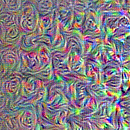

In [31]:
# This is what an input that maximizes the response of filter 0 in the target layer would look like:
display(Image("images/0.png"))

### Visualize the first 64 filters in the target layer
Now, let's make a 8x8 grid of the first 64 filters in the target layer to get of feel for the range of different visual patterns that the model has learned.

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

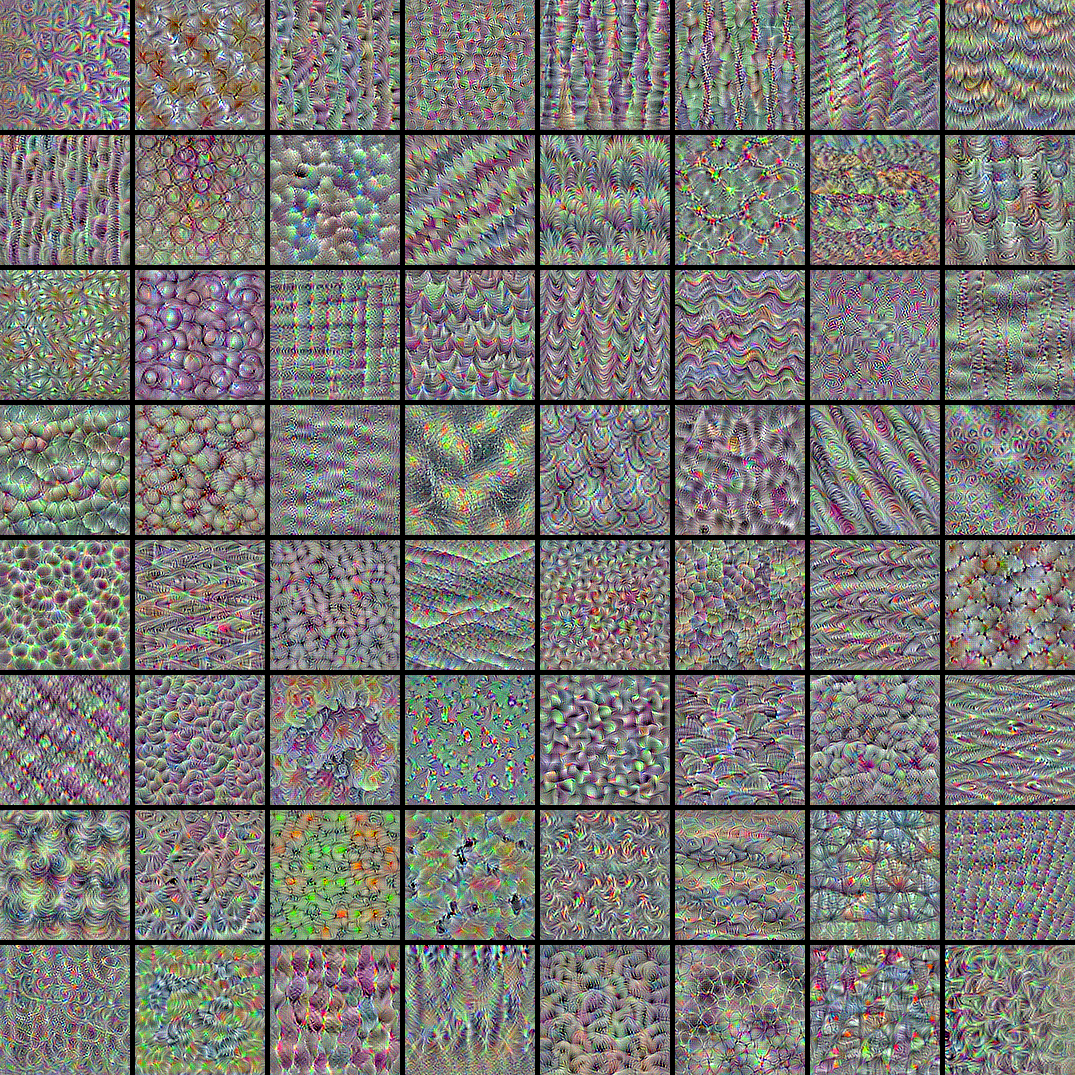

In [33]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))